## Nossa Análise de Sentimentos
    - Equipe: Jane, Leila, Jerusa e Igor
    - Data: 13 12 2019

### Trabalho Conclusão de Curso - Análise de Sentimentos usando Machine Learning
- Criando modelos para análise de sentimentos de tweets.
- detectando polaridade (positivo, negativo, neutro)
- trabalhando com classificação supervisionada e não supervisionada para criar Bag of Words


In [1]:
from nltk import word_tokenize
import nltk
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import cross_val_predict

In [2]:
# descobrindo qual diretório está fixado, lembrar que o formato é com  C:\\nome\\nome\\  
import os
os.getcwd()

# para modificar o diretório ...
# os.chdir('/')

'C:\\Users\\particular\\SERIQUE_TCC'

Para começar o treinamento, precisamos de frases com conteúdo depressivo/suicida e frases com mensagens positivas. A captura das mensagens de treino foram feitas por web scrapping, buscando nos sites: https://www.pensador.com/frases_depressivas/   e https://www.mundodasmensagens.com

In [3]:
import chardet
import pandas as pd

#with open('Depressao_msg_Treino.csv', 'rb') as f:
#with open('Suicidas_NaoSuicidas_Arquivo_de_Treino.csv', 'rb') as f:
with open('Suicidas_NaoSuicidas.csv', 'rb') as f:
 
    result = chardet.detect(f.read())  # or readline if the file is large
    
cabecalho = ['Polaridade','Frase', 'lixo']
    
#df = pd.read_csv('Depressao_msg_Treino.csv', encoding=result['encoding'], sep=';')
#df = pd.read_csv('Suicidas_NaoSuicidas_Arquivo_de_Treino.csv', encoding=result['encoding'], sep=';', header=None, names=cabecalho)
df = pd.read_csv('Suicidas_NaoSuicidas.csv', encoding=result['encoding'], sep=';', header=None, names=cabecalho)
df.head()

,Polaridade,Frase,lixo
0,Positiva,Eu tinha amigos que se cortavam então comecei ...,NaN
1,Positiva,Achei que seria facil começar e mais facil ain...,NaN
2,Positiva,"Não podia ver lâminas, facas, tesouras ou algo...",NaN
3,Positiva,Muitos me achavam louca e me julgavam mas eu n...,NaN
4,Positiva,Levou um certo tempo pra mim para com os corte...,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 3 columns):
Polaridade    486 non-null object
Frase         486 non-null object
lixo          1 non-null object
dtypes: object(3)
memory usage: 11.5+ KB


In [5]:
df[df.Polaridade=='Positiva'].count()

Polaridade    263
Frase         263
lixo            1
dtype: int64

In [6]:
df[df.Polaridade=='Negativa'].count()

Polaridade    214
Frase         214
lixo            0
dtype: int64

In [7]:
df[df.Polaridade=='Neutra'].count()

Polaridade    9
Frase         9
lixo          0
dtype: int64

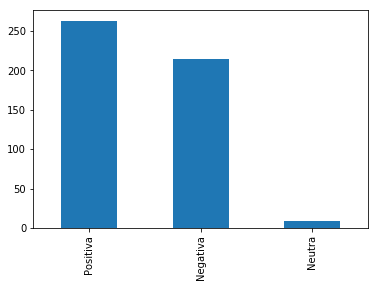

In [8]:
%matplotlib inline 
df.Polaridade.value_counts().plot(kind='bar')

In [9]:
df.count()

Polaridade    486
Frase         486
lixo            1
dtype: int64

# Pré-Processamento dos Dados
- Remove linhas duplicadas na base de dados
- Problema na coleta dos dados.
- Remove Stopwords
- Faz Stemming nos dados
- Remove caracteres indesejados como links, pontuação etc.

In [10]:
df.drop_duplicates(['Frase'], inplace=True)

In [11]:
df.Frase.count()

483

In [12]:
df['Polaridade_id'] = df['Polaridade'].factorize()[0] 

### Separando tweets e suas Classes

In [13]:
tweets = df['Frase']
classes = df['Polaridade']

### Instala bibliotecas e baixa a base de dados

In [14]:
import nltk
nltk.download('stopwords')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\particular\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\particular\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

### Funções de Pre-processamento de dados

In [15]:
def RemoveStopWords(instancia):
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    palavras = [i for i in instancia.split() if not i in stopwords]
    return (" ".join(palavras))

In [16]:
def Stemming(instancia):
    stemmer = nltk.stem.RSLPStemmer()
    palavras = []
    for w in instancia.split():
        palavras.append(stemmer.stem(w))
    return (" ".join(palavras))

In [17]:
def Limpeza_dados(instancia):
    # remove links, pontos, virgulas,ponto e virgulas dos tweets
    instancia = re.sub(r"http\S+", "", instancia).lower().replace('.','').replace(';','').replace('-','').replace(':','').replace(')','')
    return (instancia)

### Entenda como funciona cada função

In [18]:
RemoveStopWords('Um cérebro depressivo é mais triste, mas pelo menos ele sabe as verdades da vida.') 

'Um cérebro depressivo triste, menos sabe verdades vida.'

In [19]:
Stemming('Um cérebro depressivo é mais triste, mas pelo menos ele sabe as verdades da vida.') 

'um cérebr depress é mais triste, mas pel menos ele sab as verdad da vida.'

In [20]:
Limpeza_dados('Um cérebro depressivo é mais triste, mas pelo menos ele sabe as verdades da vida. https://www.uol.com.br :) ;)')

'um cérebro depressivo é mais triste, mas pelo menos ele sabe as verdades da vida   '

### Aplica as 3 funções de Pre-processamento nos dados

In [21]:
def Preprocessing(instancia):
    stemmer = nltk.stem.RSLPStemmer()
    instancia = re.sub(r"http\S+", "", instancia).lower().replace('.','').replace(';','').replace('-','').replace(':','').replace(')','')
    instancia = re.sub(r"http\S+", "", instancia).lower().replace('[','').replace(']','').replace('@','').replace('(','').replace('/','')
    instancia = re.sub(r"http\S+", "", instancia).lower().replace('#','').replace('RT @','').replace('rt cvvoficial','')
    instancia = re.sub(r"http\S+", "", instancia).lower().replace('á','a').replace('é','e').replace('í','i').replace('ó','o').replace('ú','u')
    instancia = re.sub(r"http\S+", "", instancia).lower().replace('Á','A').replace('É','E').replace('Í','I').replace('Ó','O').replace('Ú','U')
    instancia = re.sub(r"http\S+", "", instancia).lower().replace('!','').replace('?','').replace('ã','a').replace('Ã','A').replace('õ','o').replace('Õ','O')
    instancia = re.sub(r"http\S+", "", instancia).lower().replace('â','a').replace('Â','A').replace('ê','e').replace('Ê','E').replace('ô','o').replace('Ô','O')
   
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    palavras = [stemmer.stem(i) for i in instancia.split() if not i in stopwords]
    return (" ".join(palavras))

# Aplica a função em todos os dados:
tweets = [Preprocessing(i) for i in tweets]

In [22]:
Preprocessing('Um cérebro depressivo é mais triste, mas pelo menos ele sabe as verdades da vida. Assista o video aqui https:// :)')

'cerebr depress triste, menos sab verdad vid assist vide aqu'

#### Visualize os dados e veja como ficou após o pré-processamento

In [23]:
tweets[:50]

['amig cort enta comec segu exempl',
 'ach facil começ facil aind parar, engan',
 'nao pod ver laminas, facas, teso alg serv cort',
 'muit ach louc julg nao pod faz nada, poi cort oferec cert alivi força, faz esquec problem dor',
 'lev cert temp pra mim cortes, vez outr cort nao tod dia',
 'sei exist pesso entend',
 'sei nao unic pens assim',
 'escrev cart desped',
 'mei dum trist tao tremend',
 'mei dum vazi incapaz voz descrev',
 'vazi voc indiferenç nunc par ver',
 'voc dentr chor',
 'quant vez ser inconta ja sei',
 'mei voss gargalh sent tao so',
 'estranh trist coit',
 'sei ness moment esta diz cov',
 'import voc diz ja tard',
 'qu vez aqu muit vez precis',
 'nenhum voc vei dar abraç vez grit',
 'agor tir propr vid faz gent boa',
 'preocup pesso',
 'nao acredit ness voss am',
 'ness voss trist dor',
 'nao mostr am viv',
 'porqu nao fiz sent nao so',
 'nao perc voss temp chor mim',
 'poi mis final tev fim',
 'creiam, est melhor ond encaminh',
 'jeit nunc voss lad',
 'est aqu olh to

## Criando o modelo
###  Instancia o objeto que faz a vetorização dos dados de texto


In [24]:
vectorizer = CountVectorizer(analyzer="word")
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

#### Aplica o vetorizador nos dados de texto 

In [25]:
freq_tweets = vectorizer.fit_transform(tweets)
type(freq_tweets)
#print(freq_tweets.toarray())
 

scipy.sparse.csr.csr_matrix

In [26]:
modelo = MultinomialNB()
modelo.fit(freq_tweets,classes)
# print(freq_tweets.vocabulary_)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

#### Formato (Linhas, Colunas) da matriz

In [27]:
freq_tweets.shape

(483, 2490)

#### Matriz

In [28]:
freq_tweets.A

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

#### Testando o modelo com algumas instâncias simples

In [29]:
# defina instâncias de teste dentro de uma lista
testes = ['Tranquilize-se! A depressão será superada.',
          'Acabou minha tranquilidade! A depressão não foi superada.',
         'E sempre falta alguém, até festas são depressivas. Eu sei que as luzes de natal traz mais tristezas que alegria',
          'Se quer ser lembrado e nunca desprezado faça igual eles, comece a maltratar todos que você ver na rua',
          'Ele tinha um coração de pedra, mas as pedras, com o tempo também se quebram, sem qualquer chance de concerto']


#### Aplica a função de Pré-processamento nos dados

In [30]:
testes = [Preprocessing(i) for i in testes]
 

In [31]:
# Transforma os dados de teste em vetores de palavras.
freq_testes = vectorizer.transform(testes)
 

In [32]:
# Fazendo a classificação com o modelo treinado.
for t, c in zip (testes,modelo.predict(freq_testes)):
    print (t +", "+ c)
 

tranquilizes depressa ser super, Positiva
acab tranquil depressa nao super, Positiva
sempr falt alguem, ate fest sao depress sei luz natal traz trist alegr, Positiva
qu ser lembr nunc desprez faç igual eles, comec maltrat tod voc ver rua, Negativa
coraça pedra, pedras, temp tamb quebram, qualqu chanc concert, Positiva


In [33]:
# Probabilidades de cada classe
print (modelo.classes_)
modelo.predict_proba(freq_testes).round(2)

['Negativa' 'Neutra' 'Positiva']


array([[0.47, 0.  , 0.52],
       [0.14, 0.  , 0.86],
       [0.02, 0.  , 0.98],
       [0.68, 0.  , 0.32],
       [0.1 , 0.  , 0.89]])

Função de Tags de Negações
Acrescenta uma tag _NEG encontrada após um 'não'.
Objetivo é dar mais peso para o modelo identificar uma inversão de sentimento da frase.
Exemplos:
Eu gosto de cachorros, positivo.
Eu não gosto de cachorros, negativo.

In [34]:
def marque_negacao(texto):
    negacoes = ['não','not']
    negacao_detectada = False
    resultado = []
    palavras = texto.split()
    for p in palavras:
        p = p.lower()
        if negacao_detectada == True:
            p = p + '_NEG'
        if p in negacoes:
            negacao_detectada = True
        resultado.append(p)
    return (" ".join(resultado))

#### Exemplos de utilização da tag de negações

In [35]:
marque_negacao('Eu sou uma pessoa triste, as vezes me sinto cansado!')

'eu sou uma pessoa triste, as vezes me sinto cansado!'

In [36]:
marque_negacao('Eu não sou uma pessoa triste, só que as vezes me sinto cansado!')

'eu não sou_NEG uma_NEG pessoa_NEG triste,_NEG só_NEG que_NEG as_NEG vezes_NEG me_NEG sinto_NEG cansado!_NEG'

Criando modelos com Pipelines.
Pipelines são interessantes para reduzir código e automatizar fluxos.

In [37]:
from sklearn.pipeline import Pipeline

pipeline_simples = Pipeline([
  ('counts', CountVectorizer()),
  ('classifier', MultinomialNB())
])

#### Pipeline que atribui tag de negacoes nas palavras

In [38]:
pipeline_negacoes = Pipeline([
  ('counts', CountVectorizer(tokenizer=lambda text: marque_negacao(text))),
  ('classifier', MultinomialNB())
])

In [39]:
pipeline_simples.steps

[('counts',
  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
          dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
          lowercase=True, max_df=1.0, max_features=None, min_df=1,
          ngram_range=(1, 1), preprocessor=None, stop_words=None,
          strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
          tokenizer=None, vocabulary=None)),
 ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]

#### Gera o modelo de negações

In [40]:
pipeline_negacoes.fit(tweets,classes)

Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        str...      vocabulary=None)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

#### Etapas do pipeline

In [41]:
pipeline_negacoes.steps

[('counts',
  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
          dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
          lowercase=True, max_df=1.0, max_features=None, min_df=1,
          ngram_range=(1, 1), preprocessor=None, stop_words=None,
          strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
          tokenizer=<function <lambda> at 0x000002ADB5AB79D8>,
          vocabulary=None)),
 ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]

# Validando os Modelos com Validação Cruzada
- Fazendo o cross validation do modelo (divide tweets em 10 pedaços - cv=10, 9 ficam para treino e 1 para teste, calcula resultado. Repete o processo 10 vezes, sempre modificando os pedaços destinados a treino e teste. No final, apresenta a média dos resultados. Esquema é mais eficaz que o método de destinar 70/30 pq evita variância nos dados). 

In [42]:
resultados = cross_val_predict(pipeline_simples, tweets, classes, cv=10)

C:\Users\particular\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


- Medindo a acurácia média do modelo

In [43]:
metrics.accuracy_score(classes,resultados)

0.6521739130434783

- Medidas de validação do modelo
f1-score é a média harmônica de precision e recall

A precisão é a razão tp / (tp + fp) em que tp é o número de verdadeiros positivos e fp o número de falsos positivos. A precisão é intuitivamente a capacidade do classificador de não rotular como positiva uma amostra negativa.

O recall é a razão tp / (tp + fn) em que tp é o número de verdadeiros positivos e fn o número de falsos negativos. O recall é intuitivamente a capacidade do classificador de encontrar todas as amostras positivas.
 

In [44]:
sentimento=['Positiva', 'Negativa','Neutra']
print (metrics.classification_report(classes,resultados,sentimento))

              precision    recall  f1-score   support

    Positiva       0.62      0.94      0.75       260
    Negativa       0.79      0.33      0.46       214
      Neutra       0.00      0.00      0.00         9

   micro avg       0.65      0.65      0.65       483
   macro avg       0.47      0.42      0.40       483
weighted avg       0.68      0.65      0.61       483



C:\Users\particular\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


- Matriz de confusão

 

In [45]:
print (pd.crosstab(classes, resultados, rownames=['Real'], colnames=['Predito'], margins=True))

Predito   Negativa  Positiva  All
Real                             
Negativa        70       144  214
Neutra           4         5    9
Positiva        15       245  260
All             89       394  483


# Modelo com a Tag de Negações
 

In [46]:
resultados = cross_val_predict(pipeline_negacoes, tweets, classes, cv=10)

C:\Users\particular\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


- Medindo a acurácia média do modelo
 

In [47]:
metrics.accuracy_score(classes,resultados)

0.6563146997929606

Matriz de confusão
cria uma grade que apresenta o real e o que foi predito pelo modelo.
ex.       p r e v i s t o 
     r         cat   dog
     e   cat    15    35
     a   dog    40    10
     l
     
 Nessa grade exemplo:
O modelo classificou 15 instâncias como Cat e que realmente eram Cat.
O modelo classificou 35 instâncias como Dog que na verdade eram Cat.
O modelo classificou 40 instâncias como Cat que na verdade eram Dog
O modelo classificou 10 instâncias como Dog e que realmente eram Dog

In [48]:
print (pd.crosstab(classes, resultados, rownames=['Real'], colnames=['Predito'], margins=True))

Predito   Negativa  Neutra  Positiva  All
Real                                     
Negativa       125       5        84  214
Neutra           4       1         4    9
Positiva        67       2       191  260
All            196       8       279  483


## Avaliando modelo com Bigrams
 

In [49]:
vectorizer = CountVectorizer(ngram_range=(1,2))
freq_tweets = vectorizer.fit_transform(tweets)
modelo = MultinomialNB()
modelo.fit(freq_tweets,classes)
 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [50]:
resultados = cross_val_predict(modelo, freq_tweets, classes, cv=10)
 

C:\Users\particular\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


In [51]:
metrics.accuracy_score(classes,resultados)
 

0.7039337474120083

In [52]:
sentimento=['Positiva', 'Negativa','Neutra']
print (metrics.classification_report(classes,resultados,sentimento))
 

              precision    recall  f1-score   support

    Positiva       0.75      0.72      0.74       260
    Negativa       0.66      0.71      0.68       214
      Neutra       0.00      0.00      0.00         9

   micro avg       0.70      0.70      0.70       483
   macro avg       0.47      0.48      0.47       483
weighted avg       0.70      0.70      0.70       483



In [53]:
print (pd.crosstab(classes, resultados, rownames=['Real'], colnames=['Predito'], margins=True))

Predito   Negativa  Neutra  Positiva  All
Real                                     
Negativa       153       0        61  214
Neutra           9       0         0    9
Positiva        71       2       187  260
All            233       2       248  483


# Considerações Finais

- Incluir teste com outros classificadores
